# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [67]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn

## Data loading



In [68]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [69]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [70]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(501, 'international'), (802, 'season'), (836, 'son'), (667, 'outside'), (532, 'laboratory'), (368, 'exists'), (238, 'color'), (575, 'mail'), (622, 'nasa'), (457, 'heard')]


In [71]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

In [72]:
#pip install wordcloud
from wordcloud import WordCloud


### Let's look at the most frequent words in this dataset

In [73]:
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))
# Lets find the most frequence words Your code here

Nb mots= 3252437


### Plot the N frequent words and verify that its follows a Zipf law

[('the', 127670), ('to', 69836), ('of', 66705), ('a', 56148), ('and', 52580), ('is', 39554), ('in', 37787), ('I', 37616), ('that', 34582), ('>', 27843), ('for', 25707), ('you', 19874), ('it', 19698), ('be', 18364), ('on', 18201), ('have', 17292), ('are', 17260), ('with', 16179), ('not', 15434), ('The', 14079), ('this', 13611), ('as', 13373), ('or', 12497), ('was', 12426), ('Subject:', 11642), ('From:', 11536), ('Lines:', 11328), ('Organization:', 10881), ('by', 10279), ('but', 10265), ('|', 10072), ('from', 9859), ('at', 9807), ('-', 9662), ('they', 9591), ('an', 9393), ('will', 8584), ('can', 8493), ('would', 8381), ('In', 7904), ('if', 7792), ('about', 7768), ('Re:', 7747), ('my', 7679), ('--', 7639), ('writes:', 7505), ('your', 6972), ('has', 6969), ('do', 6930), ('all', 6745), ('one', 6576), ('|>', 6521), ('article', 6402), ('what', 6183), ('we', 6047), ('there', 5798), ('any', 5759), ('who', 5734), ('some', 5682), ('he', 5343), ('which', 5303), ('their', 5178), ('were', 5160), ('l

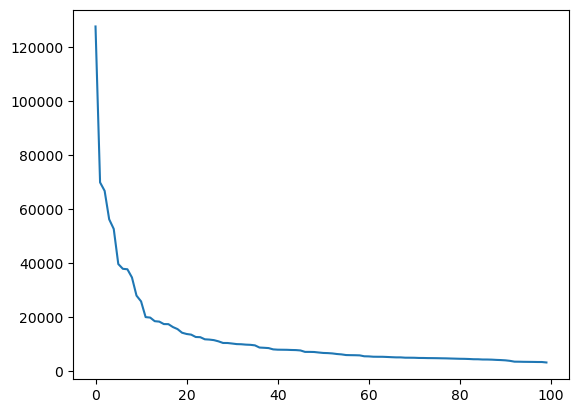

In [74]:
# Let's plot the count of the 100 most used words:

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

wc = Counter()
for text in words:
    wc.update(text.split(" "))
    
freq = [f for w,f in wc.most_common(100)]

plt.plot(freq[:100])
print(wc.most_common(100))

### Experiment word clouds

(-0.5, 399.5, 199.5, -0.5)

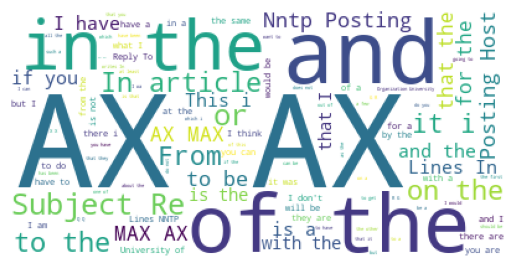

In [75]:
wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

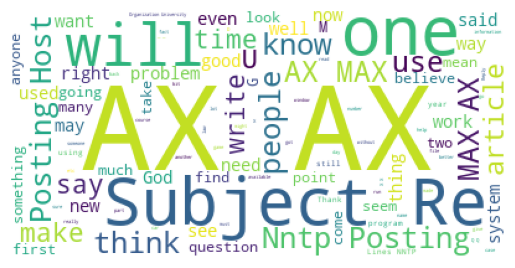

In [76]:
from wordcloud import STOPWORDS # Note: this is the default option           
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

(-0.5, 399.5, 199.5, -0.5)

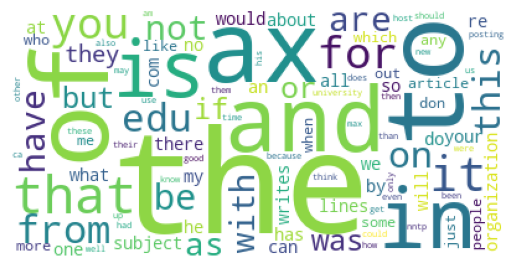

In [77]:
count_vectorizer = CountVectorizer()
x = count_vectorizer.fit_transform(newsgroups_train.data)
voc = dict(zip(count_vectorizer.get_feature_names_out(),np.asarray(x.sum(axis=0)).ravel()))

wordcloud1 = WordCloud(background_color='white', max_words=100).generate_from_frequencies(voc)

plt.figure()
plt.imshow(wordcloud1)
plt.axis("off")


### Drawing word clouds from classes


In [ ]:
# for i in range(0,20):
#     indices_k = np.where(Y ==i)[0]
#     X_k = x[indices_k]
#     #print(X_k.shape)
#     voc = dict(zip(count_vectorizer.get_feature_names_out(),np.asarray(X_k.sum(axis=0)).ravel()))

#     wordcloud1 = WordCloud(background_color='white', max_words=100).generate_from_frequencies(voc)

#     plt.figure()
#     plt.imshow(wordcloud1)
#     plt.axis("off")

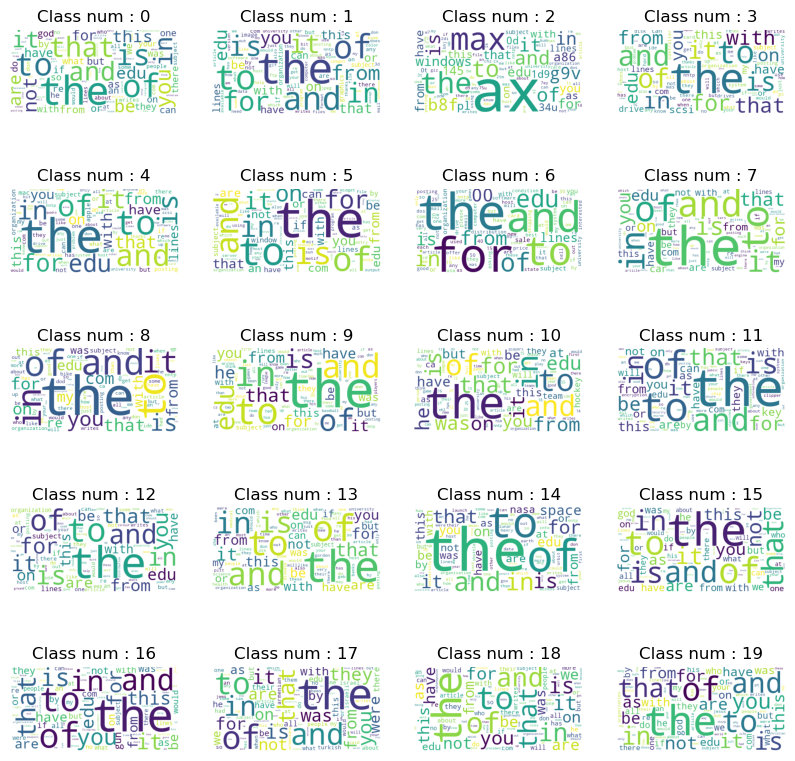

In [78]:
nb_classes = np.unique(Y)
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(10,10))
ax = ax.flatten()
for i in range(len(nb_classes)):
    indices_k = np.where(Y ==i)[0]
    X_k = x[indices_k]
    #print(X_k.shape)
    voc = dict(zip(count_vectorizer.get_feature_names_out(),np.asarray(X_k.sum(axis=0)).ravel()))

    wordcloud1 = WordCloud(background_color='white', max_words=100).generate_from_frequencies(voc)

    ax[i].imshow(wordcloud1)
    ax[i].axis("off")
    ax[i].set_title(f"Class num : {i}")
    
    

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [79]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
kmeans.cluster_centers_

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[2.64200772e-03, 1.72556979e-03, 1.10330745e-03, ...,
        5.70528778e-03, 2.72938417e-03, 2.51514002e-03],
       [3.61169636e-03, 2.67107525e-03, 6.67928714e-04, ...,
        6.99879179e-03, 2.44666453e-03, 3.15483514e-03],
       [3.23407676e-03, 2.17253305e-03, 1.94828380e-03, ...,
        4.44554390e-03, 4.06729375e-03, 8.75936802e-04],
       ...,
       [3.25722139e-03, 1.12336419e-02, 1.51121114e-03, ...,
        1.24136961e-02, 5.32988561e-03, 7.42519147e-03],
       [2.16881195e-03, 2.78943545e-02, 3.96979682e-04, ...,
        7.28880416e-03, 1.25270533e-02, 5.51950356e-03],
       [3.82974480e-03, 2.71791298e-03, 2.51429870e-03, ...,
        5.28086807e-03, 1.83526233e-03, 5.76348639e-05]])

### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

In [80]:
indices = []

# Iteration sur chaque cluster centroid
for centroid in kmeans.cluster_centers_:
    # touver l'index du mot qui a la max valeur dans le centroid
    max_index = np.argmax(np.abs(centroid))
    indices.append(max_index)

indices = np.array(indices)
print(indices)

for classe, i in enumerate(indices):
    print(f'Classe {classe} : {vectorizer.get_feature_names_out()[i]}')

[279 346 185 977 655 336 241 202 622 924 192 346 883 474 232 687 427 679
 918 519]
Classe 0 : cs
Classe 1 : edu
Classe 2 : ca
Classe 3 : windows
Classe 4 : ohio
Classe 5 : drive
Classe 6 : com
Classe 7 : cc
Classe 8 : nasa
Classe 9 : uk
Classe 10 : car
Classe 11 : edu
Classe 12 : team
Classe 13 : ibm
Classe 14 : clipper
Classe 15 : pitt
Classe 16 : god
Classe 17 : people
Classe 18 : turkish
Classe 19 : key


In [81]:
predictions = kmeans.predict(vectors)
print(predictions[:10])

[10  1 11  6  6  6  1  5 11 11]


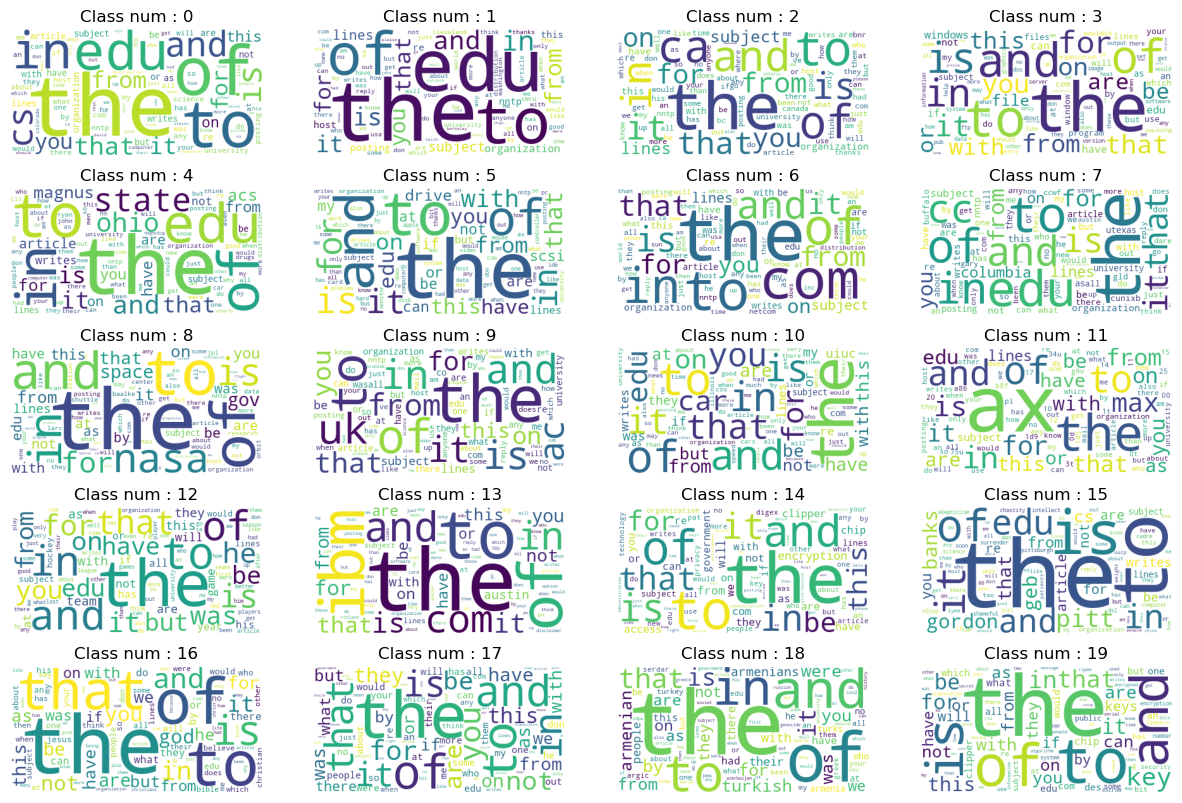

In [82]:
nb_classes = np.unique(predictions)
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,10))
ax = ax.flatten()
for i in range(len(nb_classes)):
    indices_k = np.where(predictions ==i)[0]
    X_k = x[indices_k]
    #print(X_k.shape)
    voc = dict(zip(count_vectorizer.get_feature_names_out(),np.asarray(X_k.sum(axis=0)).ravel()))

    wordcloud1 = WordCloud(background_color='white', max_words=100).generate_from_frequencies(voc)

    ax[i].imshow(wordcloud1)
    ax[i].axis("off")
    ax[i].set_title(f"Class num : {i}")

In [83]:
purity = 0
for i in range(len(nb_classes)):
    indices = np.where(predictions == i)[0]
    true_labels = Y[indices]
    unique_labels, label_counts = np.unique(true_labels, return_counts=True)
    max_count = np.max(label_counts)
    purity += max_count

purity /= len(predictions)
print(purity)

0.28106770372989215


In [84]:
from sklearn.metrics import rand_score, adjusted_rand_score
print("rand score: ", rand_score(predictions,Y))
print("adjusted rand score: ",adjusted_rand_score(predictions,Y))

rand score:  0.8831787877931313
adjusted rand score:  0.09727062319040214


# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [86]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=100,n_iter=10, random_state=0)
U = lsa.fit_transform(vectors)


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


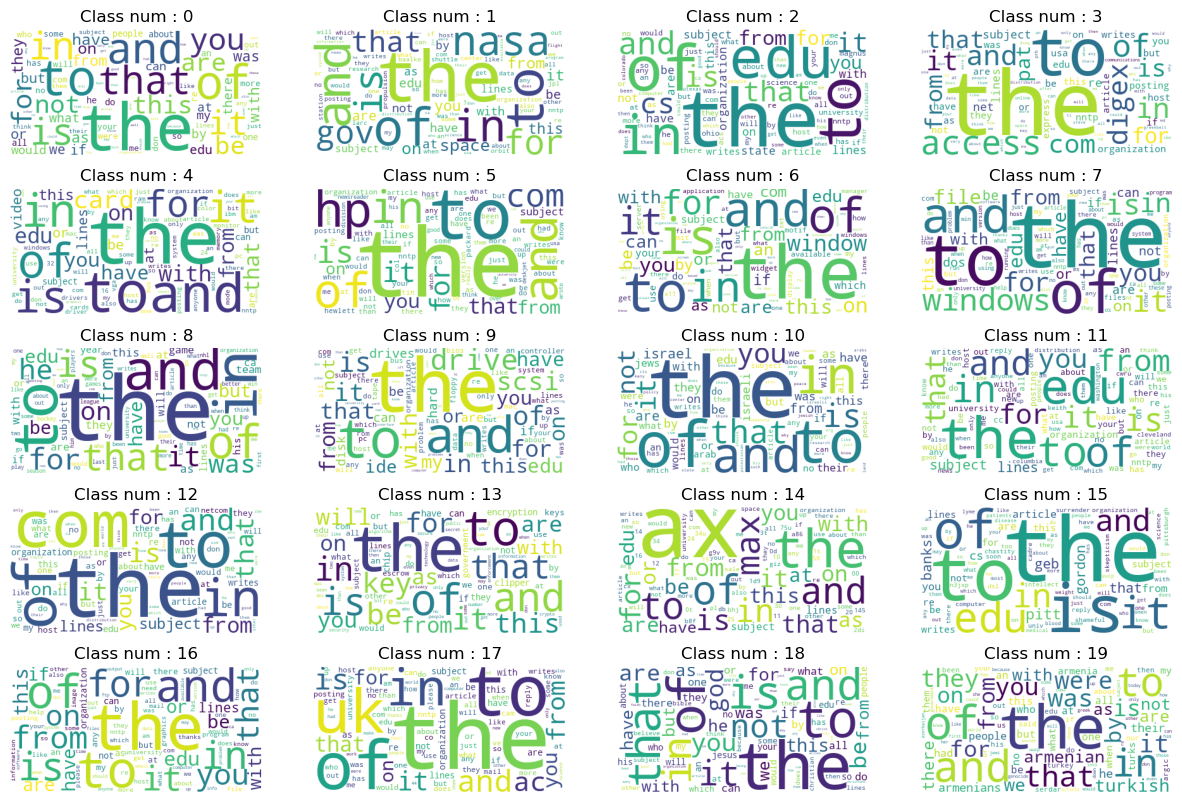

In [88]:
# sans normalisation avec la matrice U
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10).fit(U)
y_pred = kmeans.predict(U)

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,10))
ax = ax.flatten()
for i in range(len(nb_classes)):
    indices_k = np.where(y_pred ==i)[0]
    X_k = x[indices_k]
    #print(X_k.shape)
    voc = dict(zip(count_vectorizer.get_feature_names_out(),np.asarray(X_k.sum(axis=0)).ravel()))

    wordcloud1 = WordCloud(background_color='white', max_words=100).generate_from_frequencies(voc)

    ax[i].imshow(wordcloud1)
    ax[i].axis("off")
    ax[i].set_title(f"Class num : {i}")

In [89]:
purity = 0
for i in range(len(nb_classes)):
    indices = np.where(y_pred == i)[0]
    true_labels = Y[indices]
    unique_labels, label_counts = np.unique(true_labels, return_counts=True)
    max_count = np.max(label_counts)
    purity += max_count

purity /= len(y_pred)
print(purity)

0.321813682163691


In [90]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=100,n_iter=10, random_state=0)
U = lsa.fit_transform(vectors)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


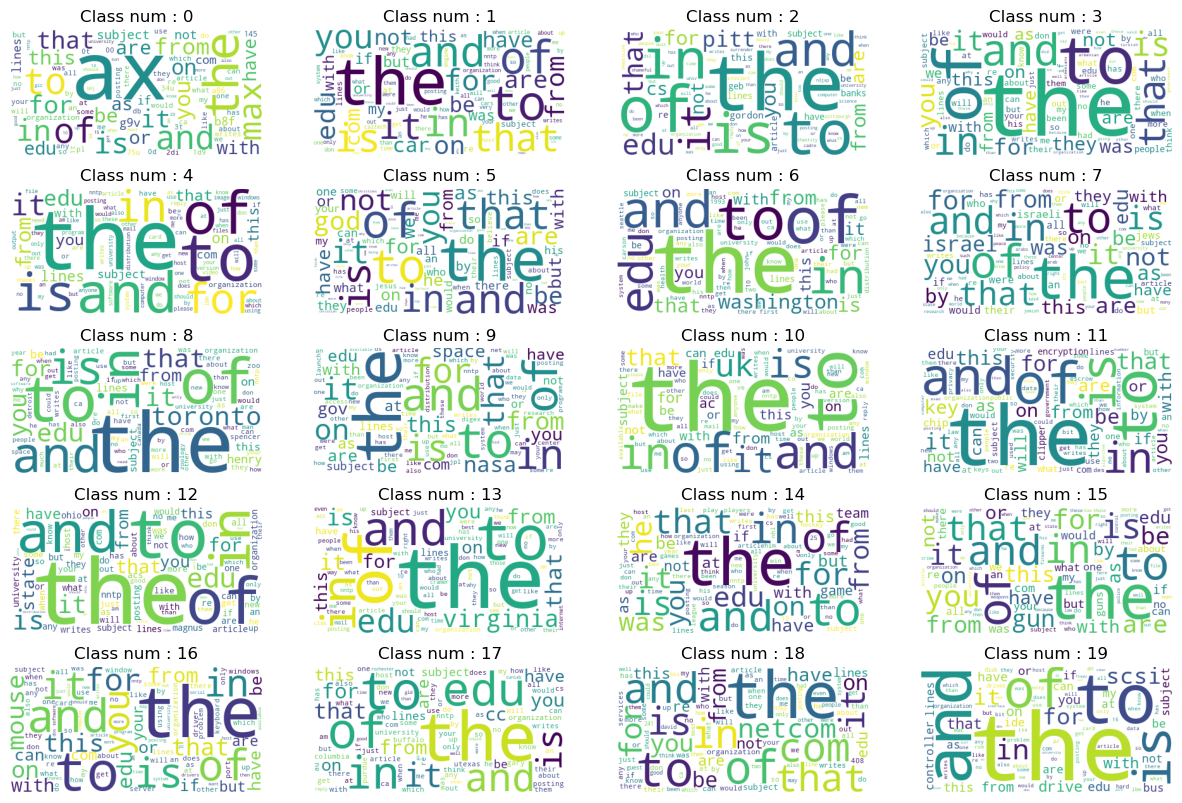

In [92]:
# avec la normalisation l2 avec la matrice U
l2_normes = np.linalg.norm(U, axis=0)
U_n = U / l2_normes

n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10).fit(U_n)
y_pred = kmeans.predict(U)

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,10))
ax = ax.flatten()
for i in range(len(nb_classes)):
    indices_k = np.where(y_pred ==i)[0]
    X_k = x[indices_k]
    #print(X_k.shape)
    voc = dict(zip(count_vectorizer.get_feature_names_out(),np.asarray(X_k.sum(axis=0)).ravel()))

    wordcloud1 = WordCloud(background_color='white', max_words=100).generate_from_frequencies(voc)

    ax[i].imshow(wordcloud1)
    ax[i].axis("off")
    ax[i].set_title(f"Class num : {i}")

In [93]:
purity = 0
for i in range(len(nb_classes)):
    indices = np.where(y_pred == i)[0]
    true_labels = Y[indices]
    unique_labels, label_counts = np.unique(true_labels, return_counts=True)
    max_count = np.max(label_counts)
    purity += max_count

purity /= len(y_pred)
print(purity)

0.316156973660951


In [87]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.002s...
[t-SNE] Computed neighbors for 11314 samples in 0.423s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.115630
[t-SNE] Computed cond

C:\Users\User\AppData\Local\Temp\ipykernel_14940\3723623928.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv', 20)
C:\Users\User\AppData\Local\Temp\ipykernel_14940\3723623928.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 20)


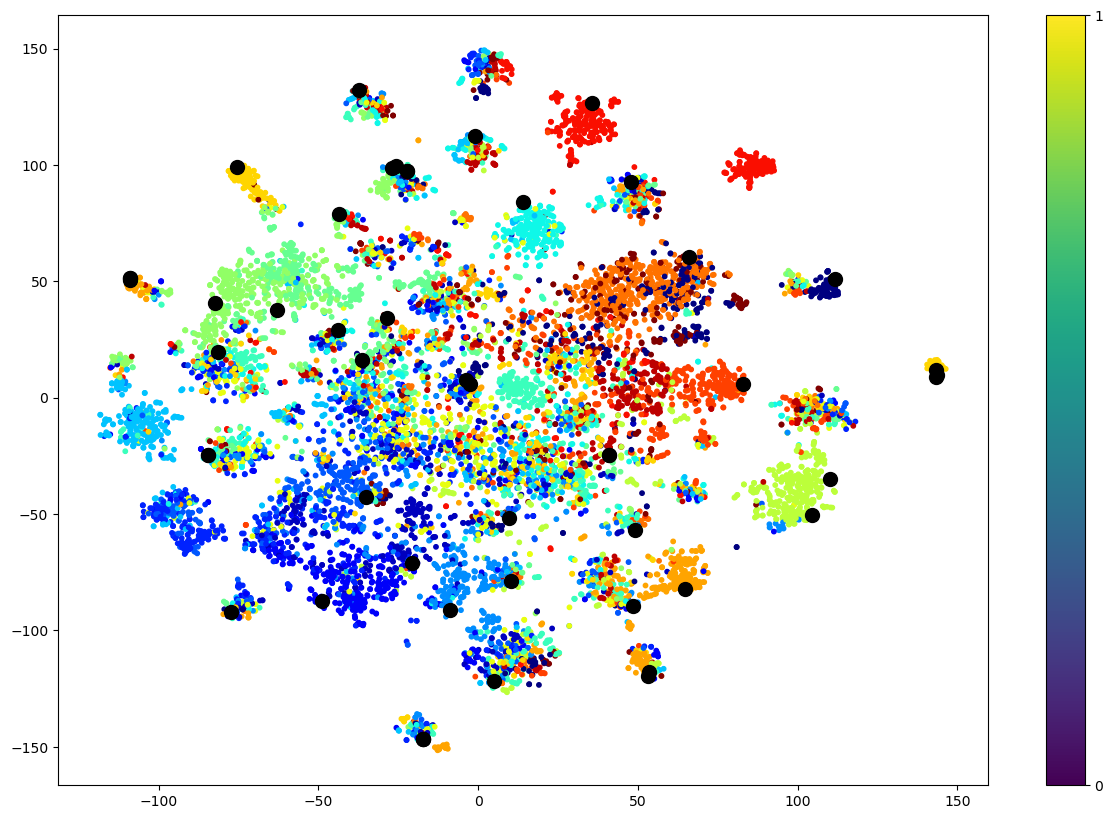

In [43]:
NN2cluster = np.argmax(np.abs(U), axis=0)
import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [44]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))



c:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(11314, 1000)
48.02527841612162


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


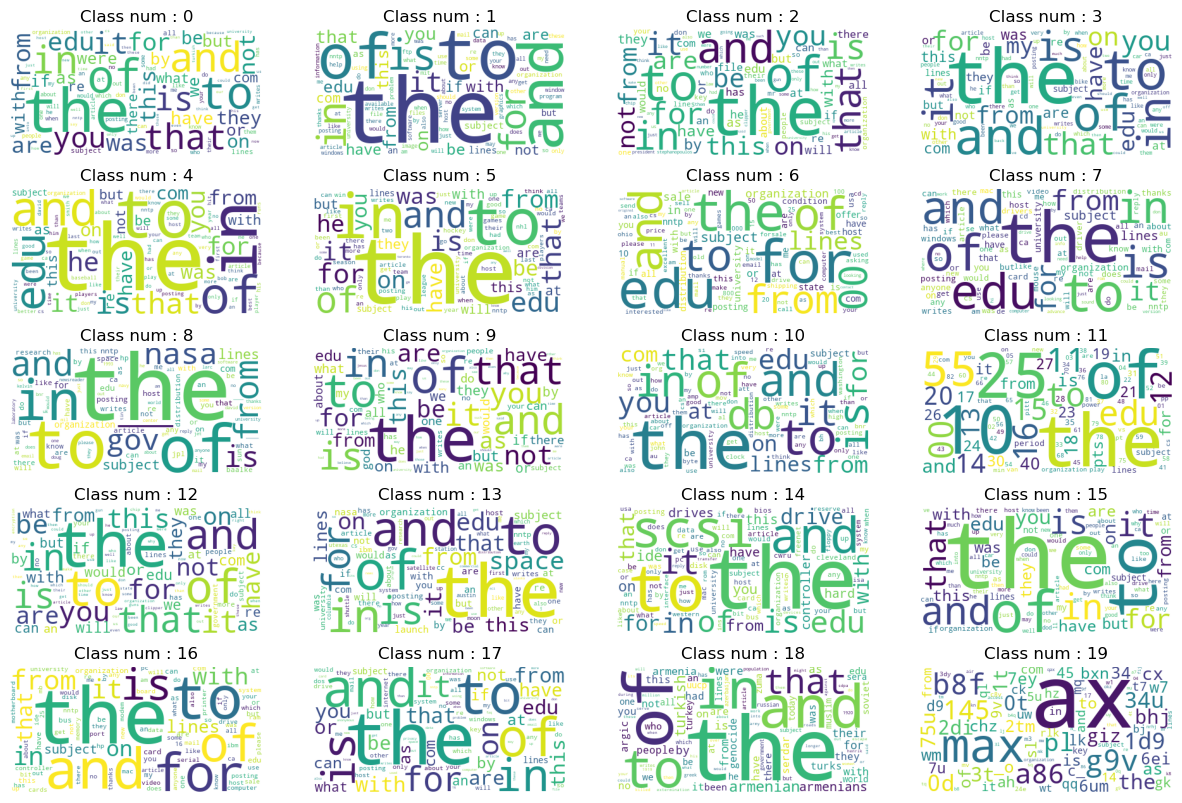

In [94]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=n_clusters, max_iter=10)
lda = lda_model.fit_transform(vectors)

kmeans_model = KMeans(n_clusters=20, random_state=0, max_iter=10)
kmeans = kmeans_model.fit(lda)

y_pred = kmeans.predict(lda)

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,10))
ax = ax.flatten()
for i in range(len(nb_classes)):
    indices_k = np.where(y_pred ==i)[0]
    X_k = x[indices_k]
    #print(X_k.shape)
    voc = dict(zip(count_vectorizer.get_feature_names_out(),np.asarray(X_k.sum(axis=0)).ravel()))

    wordcloud1 = WordCloud(background_color='white', max_words=100).generate_from_frequencies(voc)

    ax[i].imshow(wordcloud1)
    ax[i].axis("off")
    ax[i].set_title(f"Class num : {i}")


In [95]:
purity = 0
for i in range(len(nb_classes)):
    indices = np.where(y_pred == i)[0]
    true_labels = Y[indices]
    unique_labels, label_counts = np.unique(true_labels, return_counts=True)
    max_count = np.max(label_counts)
    purity += max_count

purity /= len(y_pred)
print(purity)

0.32879618172176067


## LDA-viz

In [97]:
# pip install install pyldavis
from __future__ import print_function

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda,vectors,vectorizer)

ModuleNotFoundError: No module named 'pyLDAvis.sklearn'

# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**